In [ ]:
import zipfile
!rm /content/download
!rm -r /content/imagedb/
!rm -r /content/imagedb_test
!wget https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
local_zip = '/content/download'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

train_dir = '/content/imagedb'
test_dir = '/content/imagedb_test'


rm: cannot remove '/content/download': No such file or directory
rm: cannot remove '/content/imagedb/': No such file or directory
rm: cannot remove '/content/imagedb_test': No such file or directory
--2023-01-30 14:20:22--  https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181682323 (173M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 173.27M  11.2MB/s    in 17s     

2023-01-30 14:20:41 (10.4 MB/s) - ‘download’ saved [181682323/181682323]



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
#Load the ResNet50V2 model
mypretrained=tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),pooling='avg',classes=34)


94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers except the last 20 layers
for layer in mypretrained.layers[:-20]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in mypretrained.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1330169460> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f12cc099310> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f12cc0995e0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f12cc0995b0> False
<keras.layers.core.activation.Activation object at 0x7f12cc099a90> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f12c0301820> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f12c02b14f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f12c02b1520> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f12c02c4af0> False
<keras.layers.core.activation.Activation object at 0x7f12c02b7580> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f12c02beaf0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f12c02b1310> False
<keras.layers.c

In [ ]:
from keras import models
from keras import layers
from keras import optimizers


# Create the model
model = models.Sequential()

# Add the resnet base model
model.add(mypretrained)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(34, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 34)                17442     
                                                                 
Total params: 24,654,242
Trainable params: 8,948,770
Non-trainable params: 15,705,472
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Initialize the ImageDataGenerator with preprocessing, augmentation options, and validation split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  # Preprocess input as per MobileNetV2 requirements
                                   brightness_range=[0.1, 1],  # Randomly adjust brightness
                                   shear_range=30,  # Apply shear transformation
                                   rotation_range=15,  # Randomly rotate images
                                   zoom_range=0.1,  # Randomly zoom into images
                                   validation_split=0.2)  # Split data for validation

# Generate batches of tensor image data for training, with data augmentation
train_generator = train_datagen.flow_from_directory(train_dir,  # Directory with training images
                                                    batch_size=100,  # Number of images to process at a time
                                                    class_mode='categorical',  # Type of class labels
                                                    target_size=(224, 224),  # Resize images to match model input size
                                                    shuffle=True)  # Shuffle the data for randomness

# Generate batches of tensor image data for validation
validation_generator = train_datagen.flow_from_directory(train_dir,  # Directory with training images
                                                         batch_size=100,  # Number of images to process at a time
                                                         class_mode='categorical',  # Type of class labels
                                                         target_size=(224, 224),  # Resize images to match model input size
                                                         subset='validation',  # Use the validation subset
                                                         seed=1)  # Seed for reproducibility


Found 3056 images belonging to 34 classes.
Found 599 images belonging to 34 classes.


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
              metrics=['acc'])


callbacks = []
save_best_callback = tf.keras.callbacks.ModelCheckpoint(f'best_weights.hdf5', save_best_only=True, verbose=1)
callbacks.append(save_best_callback)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
callbacks.append(early_stop_callback)

# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=50,
      validation_data=validation_generator,
      verbose=1,
      callbacks=callbacks)

# Save the model
model.save('ioannaspretrained.h5')

<ipython-input-6-d43d56020733>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
31/30 [==============================] - ETA: 0s - loss: 2.2061 - acc: 0.4512
Epoch 1: val_loss improved from inf to 0.91454, saving model to best_weights.hdf5
30/30 [==============================] - 65s 2s/step - loss: 2.2061 - acc: 0.4512 - val_loss: 0.9145 - val_acc: 0.7613
Epoch 2/50
31/30 [==============================] - ETA: 0s - loss: 0.7879 - acc: 0.8125
Epoch 2: val_loss improved from 0.91454 to 0.33499, saving model to best_weights.hdf5
30/30 [==============================] - 47s 2s/step - loss: 0.7879 - acc: 0.8125 - val_loss: 0.3350 - val_acc: 0.9065
Epoch 3/50
31/30 [==============================] - ETA: 0s - loss: 0.3926 - acc: 0.9031
Epoch 3: val_loss improved from 0.33499 to 0.15075, saving model to best_weights.hdf5
30/30 [==============================] - 46s 2s/step - loss: 0.3926 - acc: 0.9031 - val_loss: 0.1508 - val_acc: 0.9533
Epoch 4/50
31/30 [==============================] - ETA: 0s - loss: 0.2077 - acc: 0.9440
Epoch 4: val_loss improved from 0

In [ ]:
test_datagen  = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=100,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(224,224))
loss, acc = model.evaluate(test_generator)

Found 2149 images belonging to 34 classes.
22/22 [==============================] - 9s 383ms/step - loss: 0.1713 - acc: 0.9609


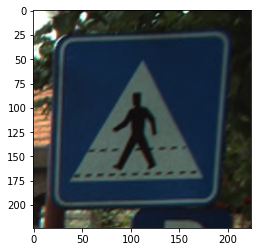

1/1 [==============================] - 1s 1s/step



['00004', '00005', '00007', '00008', '00010', '00012', '00013', '00017', '00018', '00019', '00021', '00027', '00028', '00029', '00030', '00031', '00032', '00034', '00035', '00037', '00038', '00039', '00041', '00042', '00043', '00045', '00047', '00051', '00053', '00054', '00056', '00057', '00058', '00059']



Softmax Output: [[3.1074469e-03 7.6176430e-04 2.2143627e-02 1.3156755e-02 3.4252582e-05
  1.3132424e-03 4.1259700e-03 6.2375463e-04 2.6128814e-03 4.3796333e-03
  4.8603876e-03 3.6227203e-04 2.5534118e-04 2.9468213e-04 1.2756969e-03
  3.1238334e-04 9.8530698e-05 1.1388394e-03 1.9978565e-04 4.4899137e-04
  2.1128510e-03 3.0770883e-04 6.5069663e-04 7.0689828e-05 1.3243553e-04
  3.1467299e-03 5.6687795e-04 2.4770604e-02 8.6350702e-03 1.5860853e-03
  8.6854428e-01 1.4051462e-02 1.4732654e-03 1.2445095e-02]]



/content/imagedb_test/00056/00125_00000.ppm is a 00056





In [ ]:
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

path = '/content/imagedb_test/00056/00125_00000.ppm'
img = load_img(path, target_size=(224, 224), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

model = tf.keras.models.load_model('/content/best_weights.hdf5')
x = img_to_array(img)
x = np.expand_dims(x, axis=0)

classes_pred = model.predict(x)
classes = ['00004', '00005', '00007', '00008', '00010', '00012', '00013', '00017', '00018', '00019', '00021', '00027', '00028'
            , '00029', '00030', '00031', '00032', '00034', '00035', '00037', '00038', '00039', '00041', '00042', '00043', '00045'
            , '00047', '00051', '00053', '00054', '00056', '00057', '00058', '00059']
print(f'\n\n\n{classes}')
print(f'\n\n\nSoftmax Output: {classes_pred}')
print(f'\n\n\n{path} is a {classes[classes_pred.argmax()]}\n\n\n')